# **Image Transformation**

This book will explore using `OpenCV` to transform a forward facing image taken from a vehicle into a bird-eye view.

## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from src.utility import *

## Functions

In [2]:
def plot_channels(dict, title, nrows=1, ncols=3, figsize=(12, 3)):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axs = axs.flatten()
    for channel, ax in zip(dict, axs):
        ax.imshow(dict[channel], cmap='gray')
        ax.title.set_text(channel)
        ax.axis(False)
    fig.suptitle(title)
    plt.show()

## **Motivation**

Imagine standing in the middle of a long stretch of road. The is a solid lane marker to your left and right that extends the entire length of the road. As you focus on the middle portion of the road, you'll see that the lane lines look almost like they are converging though you know they run in parallel. We can see the same phenomenon with pictures taken from cameras. For example, let's take a look at a test image. Pay attention to how the lane lines seem to converge the further out they go.

<div>
<img src="test_images/straight_lines1.jpg" width="1000"/>
</div>

The point in the horizon that the lines seem to converge to is known as the vanishing point and the reason as to why they seem to converge has to do with dimunation. That is the further out we look, the smaller the objects look resulting in a convergin perspective. This is great and all, but what does it have to do with our computer vision application? Well we inherintly know that though they may look it, the lines do not converge. The computer, however, just sees an image of lines that seem to get closer to one another as we move up the image. Thought we may be able to detect the polylines of lane lines, if we want to include any measurments (distance, radius, etc.) the results will not be an accurate representation of the real-life measurements

## **Bird's Eye View**

To remedy this, we can transform our image into a birds-eye view such that we have a top-down flat representation of the lane ahead. This perspective will allow us to calculate various measurments with confidence of accurate represenation. Let's take a look at the image we will try to transform.

<div>
<img src="test_images/test2.jpg" width="1000"/>
</div>

We see that the vehicle is moving through a left turn curve, however the perspective phenomenon makes it seem like the left turn has yet to come. The birds-eye view might show otherwise.

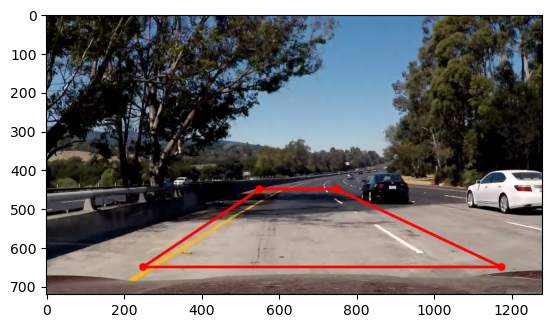

In [3]:
orig_img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

roi_points = np.int32([[
    (550, 450),
    (250, 650),
    (1175, 650),
    (750, 450)
]])

img = draw_roi(img, roi_points, (255, 0, 0))

plt.imshow(img)

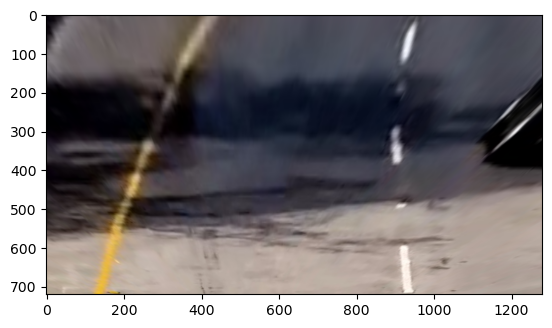

In [4]:
src_points = np.float32(roi_points.reshape(-1, 2))

dst_points = np.float32([
    (100, 0),
    (100, 750),
    (1100, 750),
    (1100, 0)
])

matrix = cv2.getPerspectiveTransform(src_points, dst_points)
result = cv2.warpPerspective(orig_img, matrix, (orig_img.shape[1], orig_img.shape[0]))
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

plt.imshow(result)

## **Thresholding**

Though we have the bird's eye view of the road ahead, we still need to do a bit more image processing before curve detection. Right now our image is coloured which makes it difficult to seperate the features we are interested in from the background. It would be better to work with a binary image where the background is black and the lane lines are white. Instead of using a RGB image, we can explore using `HLS` (hue, lightness, saturation) or `HSV` (hue, saturation, value) colour spaces. Let's see what each one actually represents.

### **HLS**

1) **Hue**

    The hue channel represents the colours in the image as an angle of the standardized colour wheel. Where 0/360 is red, 120 is green, and 240 is blue.

2) **Lightness**

    The lightness channel represents the overall brightness of the image from balck (0) to white (1). In essence, this channel describes the shadows and highlights of an image.

3) **Saturation**

    The saturation channel represents the purity of the colors in the image. It ranges from a middle-grey (0) to the purist possibility (1). This channel is useful for image segmentation based on objects that are highly vivid and/or dull.

### **HSV**

1) **Hue**

    This channel is the exact same for both colour spaces.

2) **Saturation**

    Similar to HSL, the saturation channel describes the purity of the colours. However, the values range from white (0%) to the purist possibility (100%) instead.

3) **Value**

    The value channel describes the brightness of the colours ranging from the darkest (0%) and purist (100%) values of the colours.

From reading this you might feel like the two colour spaces are similar, however there are some intricate differences in how each space can be used. You can explore this topic more in this well-structured [article](https://www.tobiamontanari.com/hsl-and-hsv-explained-which-color-model-should-you-use/). Let's take a look at each channel from both color spaces using our bird's-eye view image.

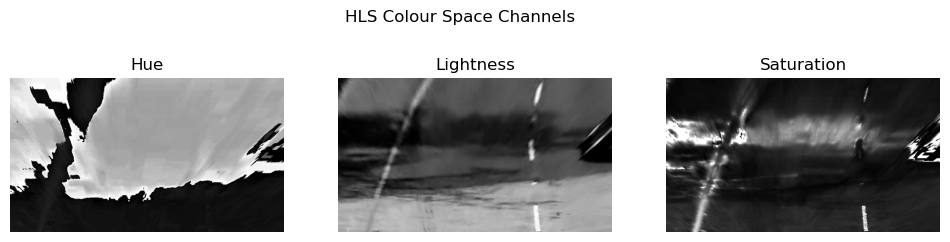

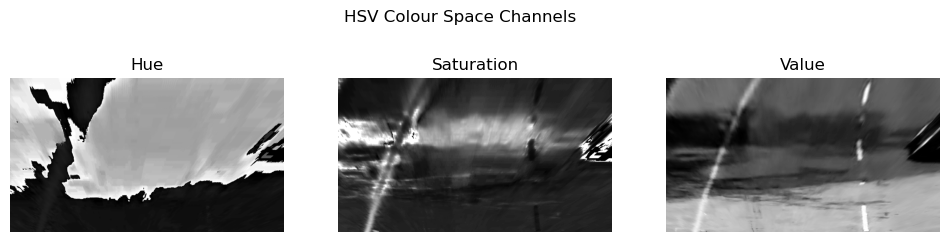

In [5]:
hls = cv2.cvtColor(result, cv2.COLOR_RGB2HLS)
hsv = cv2.cvtColor(result, cv2.COLOR_RGB2HSV)

hls_dict = {
    'Hue' : hls[:,:,0],
    'Lightness' : hls[:,:,1],
    'Saturation' : hls[:,:,2]
}

hsv_dict = {
    'Hue' : hsv[:,:,0],
    'Saturation' : hsv[:,:,1],
    'Value' : hsv[:,:,2]
}

plot_channels(hls_dict, title='HLS Colour Space Channels')
plot_channels(hsv_dict, title='HSV Colour Space Channels')

From the outputs above it seems like both the `Value` channel from the `HSV` colour space and the `Lightness` channel from `HLSC` are doing a good job at seperating the lane lines from the road. Though the outputs are similar, the biggest difference is tha the left solid line is more intense in the Value channel as compared to the Light channel. Remeber that the Value channel looks at the brightness of the colours from dark to the **purest** value and the lightness channel looks at the brightness from dark to **white**. Meaning that if we are going to have coloured lines (and markings) on the road, it would be better to go with the Value channel.

### **Binary Thresholding**

We now have an image that gives us a good foundation to move forward. The next step is to take this image and transform it into a binary representation where the pixel we keep are determined using a threshold range. Note that we want to keep only the brightest pixels and that the Value channels pixel intensities range from 0 (least-intense) to 255 (most-intense). Knowing this we can specify a range of intensities from which only the pixels in that range will be kept. Let's try out a range of 200 to 255.

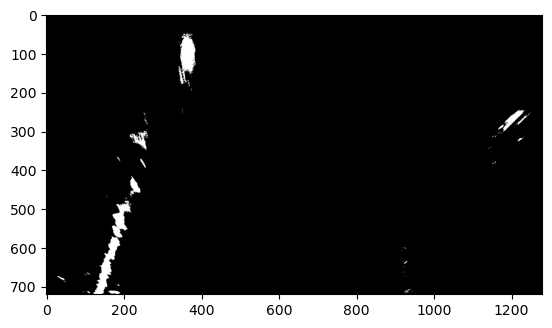

In [6]:
test = np.zeros_like(hsv[:,:,0])
test[(hsv[:,:,0] >= 20) & (hsv[:,:,0] <= 30)] = 1
plt.imshow(test, cmap='gray')

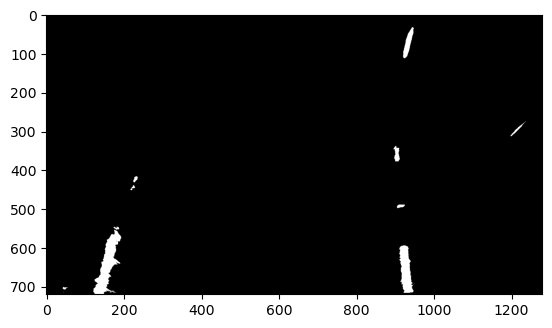

In [7]:
v_channel = hsv_dict['Value']
thresh = (210, 255)

output = np.zeros_like(v_channel)
output[(v_channel >= thresh[0]) & (v_channel <= thresh[1])] = 1

plt.imshow(output, cmap='gray')
plt.imsave('book_images/threshold.png', output, cmap='gray')

Great! Now we have a binary image showing only the lane markers. The next step is to fit a polyline for the left and right lane lines.

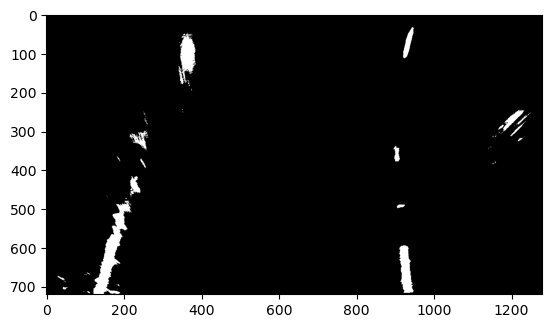

In [8]:
plt.imshow(output | test, cmap = 'gray')